In [78]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob

#import geopandas as gpd
import pandas as pd

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

# from utils import *
# from utils import basics as bsc
# from utils import plotting as pt

import utils.basics as bsc 
import utils.plotting as pt

# import importlib
# importlib.reload(pt)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
# PATHS
S2_stacked_1 = "../data/02_processed/S2_Stacked_Site_1.tif"
S2_stacked_2 = "../data/02_processed/S2_Stacked_Site_2.tif"
ALS_PATH1_RES = "../data/02_processed/ALS_resampled_site1.tif"
ALS_PATH2_RES = "../data/02_processed/ALS_resampled_site2.tif"

## load rasters

In [66]:
# Load S2 and merged ALS data for both sites and combine them in an array
s2_np, als_np = bsc.load_rasters(S2_stacked_1, ALS_PATH1_RES)
s2_np2, als_np2 = bsc.load_rasters(S2_stacked_2, ALS_PATH2_RES)

✅ Loaded S2: (13, 846, 1241), ALS: (846, 1241)
S2_Stacked_Site_1.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

ALS_resampled_site1.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

✅ Loaded S2: (13, 1002, 815), ALS: (1002, 815)
S2_Stacked_Site_2.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 9.99 x 10.00 metre

ALS_resampled_site2.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 9.99 x 10.00 metre



## plot the images

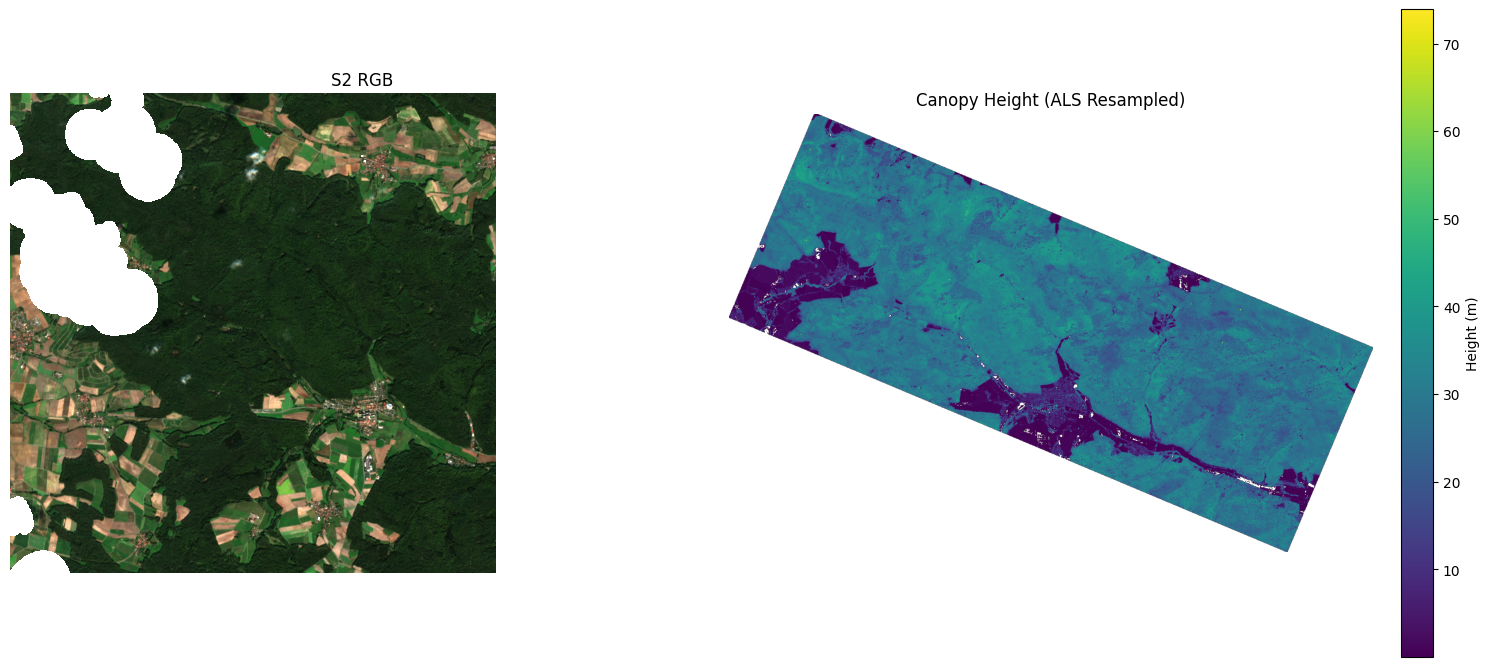

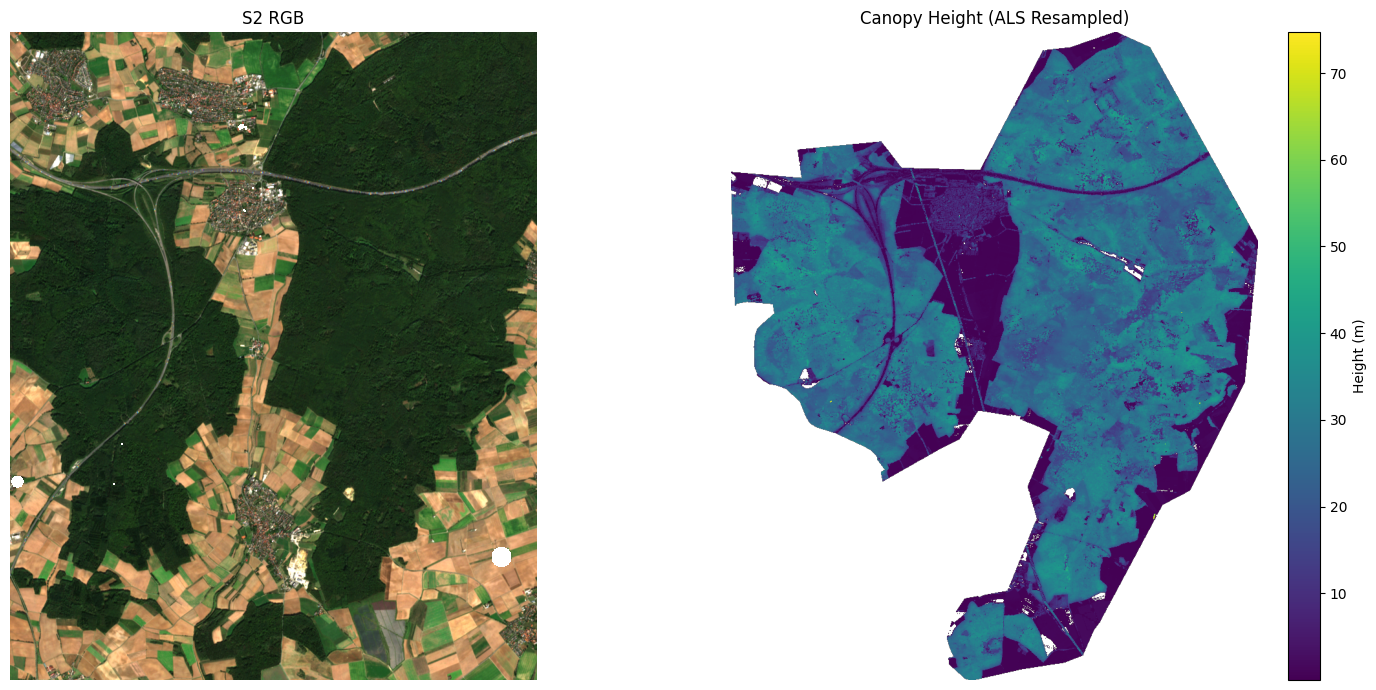

In [67]:
pt.plot_full_image(s2_np, als_np)
pt.plot_full_image(s2_np2, als_np2)

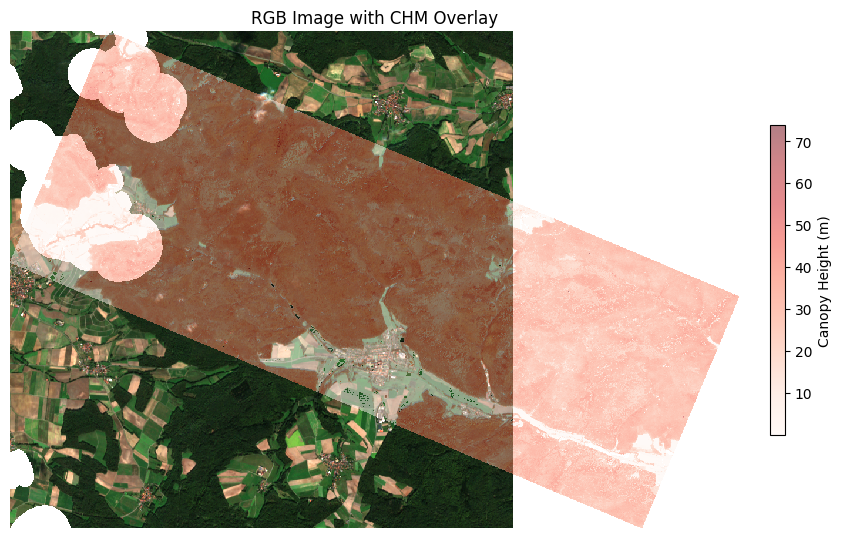

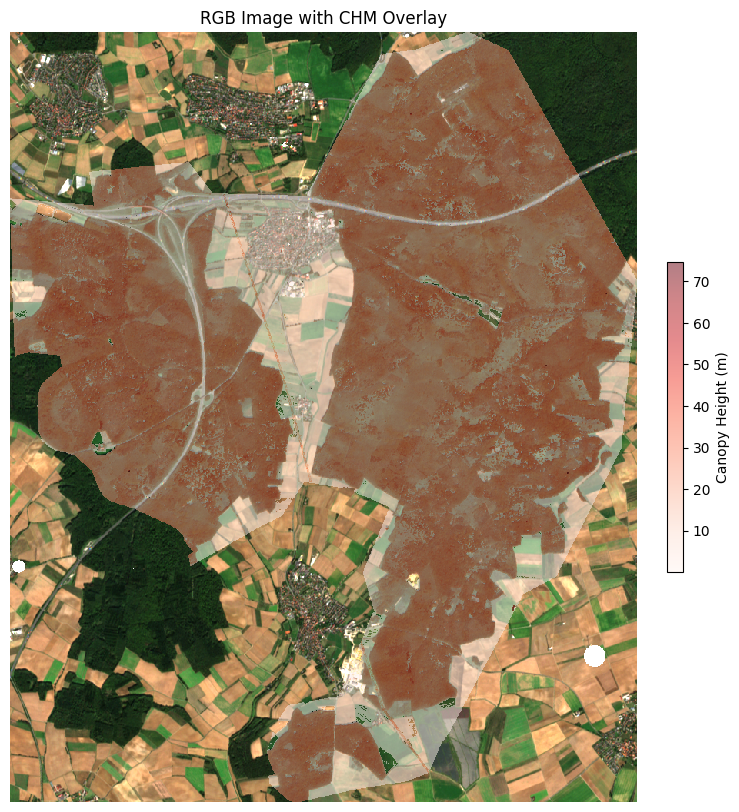

In [68]:
pt.plot_overlay(s2_np, als_np)
pt.plot_overlay(s2_np2, als_np2)

## get data stats

In [18]:
# Get file sizes in megabytes (MB)
als_file_size = os.path.getsize(ALS_PATH2_RES) / (1024 * 1024)  # Convert bytes to MB
s2_file_size = os.path.getsize(S2_stacked_2) / (1024 * 1024)  # Convert bytes to MB

print(f"ALS file size: {als_file_size:.2f} MB")
print(f"S2 stacked multiband file size: {s2_file_size:.2f} MB")

ALS file size: 3.12 MB
S2 stacked multiband file size: 20.25 MB


In [87]:
def calculate_coverage_and_area(als, s2, band_idx=3, pixel_size=10):
    """
    Calculate the coverage and overlap between ALS and a specific S2 band.

    Parameters:
    - als: numpy array of ALS data (height, width)
    - s2: numpy array of S2 data (bands, height, width)
    - band_idx: index of the S2 band to compare (default: 3 for green channel)
    - pixel_size: size of one pixel in meters (default: 10m x 10m)

    Returns:
    - valid_pixel_count: number of valid overlapping pixels
    - percentage: percentage of ALS pixels with valid S2 data
    - area: area in square meters of valid overlapping pixels
    """
    # Mask invalid ALS and S2 data
    als_valid = ~np.isnan(als) & (als >= 0)
    s2_valid = ~np.isnan(s2[band_idx]) & (s2[band_idx] >= 0)

    # Calculate overlap
    valid_overlap = als_valid & s2_valid
    valid_pixel_count = np.sum(valid_overlap)

    # Calculate percentage and area
    total_als_pixels = np.sum(als_valid)
    percentage = (valid_pixel_count / total_als_pixels) * 100 if total_als_pixels > 0 else 0
    als_area_full = np.sum(als_valid) * (pixel_size ** 2) / 1e6   # Area in square kilometers
    area_km2_avail = valid_pixel_count * (pixel_size ** 2) / 1e6  # Convert to square kilometers

    # Calculate percentage of vegetated area with data availability
    vegetated_area = np.sum((als > 2) & ~np.isnan(als))
    vegetated_overlap = np.sum((als > 2) & valid_overlap)
    vegetated_percentage = (vegetated_overlap / vegetated_area) * 100 if vegetated_area > 0 else 0

    print(f"ALS area (all valid CHM):             {als_area_full:10.2f} km²")
    print(f"Valid overlapping pixels:               {valid_pixel_count:10,d}")
    print(f"Area of valid overlapping pixels:     {area_km2_avail:10.2f} km²")
    print(f"ALS pixels with valid S2 data:        {percentage:10.2f} %")
    print(f"Vegetated area with data availability:{vegetated_percentage:10.2f} % (CHM > 2m)")

    return #valid_pixel_count, percentage, als_area_full, area_km2_avail, vegetated_percentage


In [88]:
calculate_coverage_and_area(als_np, s2_np, band_idx=3)

ALS area (all valid CHM):                  49.85 km²
Valid overlapping pixels:                  303,737
Area of valid overlapping pixels:          30.37 km²
ALS pixels with valid S2 data:             60.93 %
Vegetated area with data availability:     61.06 % (CHM > 2m)


In [58]:
calculate_coverage_and_area(als_np2, s2_np2, band_idx=3)

ALS area (all valid CHM):                  44.41 km²
Valid overlapping pixels:                  444,046
Area of valid overlapping pixels:          44.40 km²
ALS pixels with valid S2 data:            100.00 %
Vegetated area with data availability:    100.00 % (CHM > 2m)


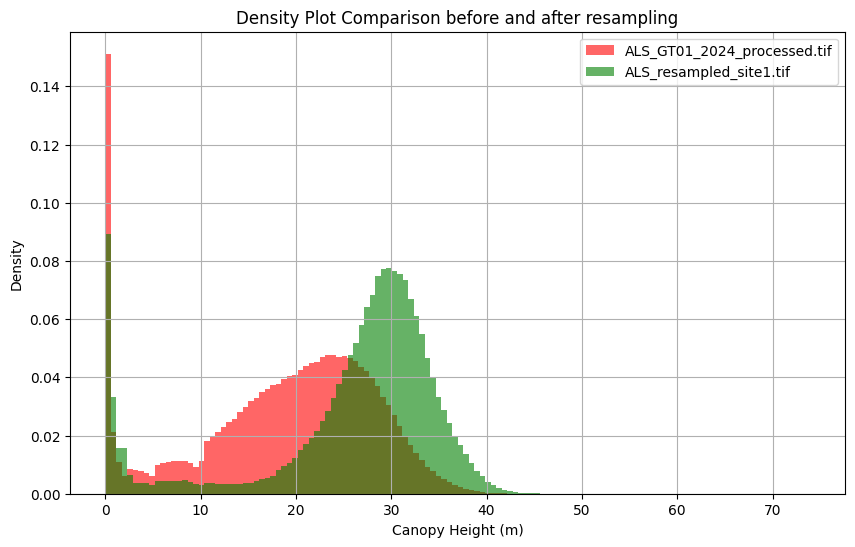


Percentiles Table:
            ALS_GT01_2024_processed.tif  ALS_resampled_site1.tif  delta
Percentile                                                             
0th                                0.00                     0.01   0.01
5th                                0.13                     0.56   0.43
10th                               1.18                     5.09   3.91
50th                              20.50                    28.55   8.05
75th                              25.91                    31.85   5.94
90th                              29.66                    34.66   5.00
95th                              31.70                    36.41   4.71
98th                              33.98                    38.25   4.27
99th                              35.46                    39.43   3.97
100th                             73.91                    73.91   0.00


In [95]:
pt.plot_two_density_and_percentiles(ALS_PATH1_P, ALS_PATH1_RES)

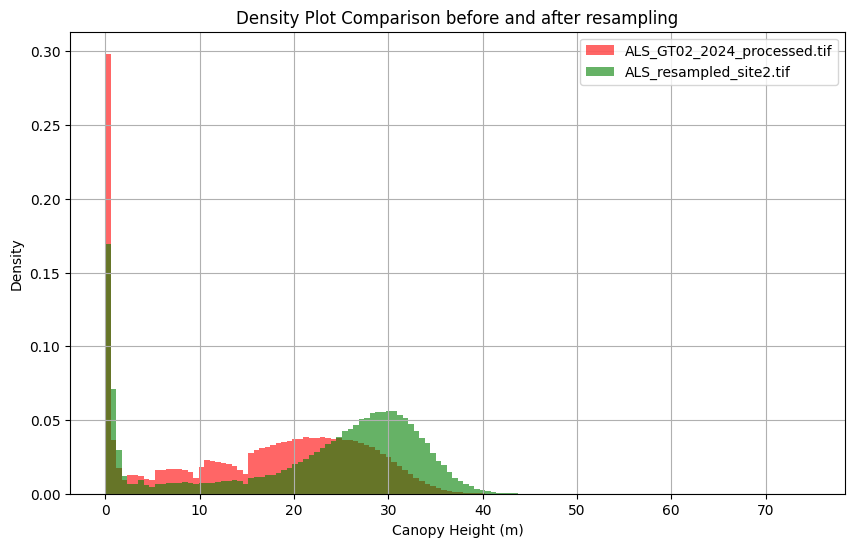


Percentiles Table:
            ALS_GT02_2024_processed.tif  ALS_resampled_site2.tif  delta
Percentile                                                             
0th                                0.00                     0.01   0.01
5th                                0.08                     0.39   0.31
10th                               0.20                     0.60   0.40
50th                              17.93                    25.78   7.85
75th                              24.69                    30.57   5.88
90th                              29.05                    33.67   4.62
95th                              31.11                    35.31   4.20
98th                              33.21                    37.14   3.93
99th                              34.55                    38.34   3.79
100th                             74.69                    74.69   0.00


In [94]:
pt.plot_two_density_and_percentiles(ALS_PATH2_P, ALS_PATH2_RES)

--> Cool, this distribution is somehow expected when doing a 98th percentile aggregation. We shift the distribution slightly to the right. 